In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
import time

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


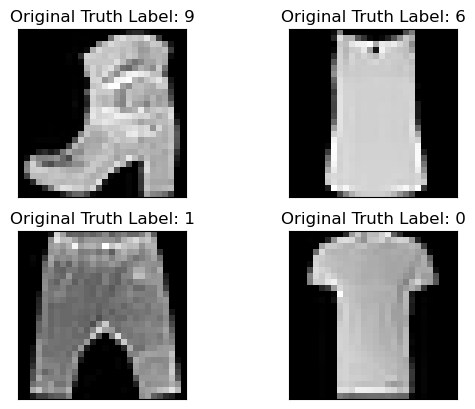

In [3]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)
print(labels.shape)

fig = plt.figure()
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title("Original Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
plt.show()

In [12]:
# Transfer learning
model = torchvision.models.resnet18(pretrained=True)
# Move the model to the selected device
model.to(device)

# Modify the first convolutional layer to accept single-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)

# Remove the final fully connected layers
model = nn.Sequential(*list(model.children())[:-1])  # Remove the last fully connected layer

# Freeze the parameters so they are not updated during training
for param in model.parameters():
    param.requires_grad = False

# Define a function to extract features
def extract_features(loader, model):
    features = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
    return np.concatenate(features)

# Extract features from the train and test datasets
train_features = extract_features(trainLoader, model)
test_features = extract_features(testLoader, model)


# Now train GaussianMixture model on these extracted features
# Reshape the features to have only two dimensions
train_features_2d = train_features.reshape(-1, train_features.shape[-1])
test_features_2d = test_features.reshape(-1, test_features.shape[-1])

# Now train your GMM or any other model on these extracted features
# Example:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5)
gmm.fit(train_features_2d)

/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GaussianMixture(n_components=5)

In [17]:
# Generate images using GMM
def generate_images(gmm, num_images=10):
    # Sample from the GMM
    samples, _ = gmm.sample(num_images)
    
    # Reshape the samples to match the input size of the decoder (e.g., 28x28)
    height, width = 28, 28  # Original size of FashionMNIST images
    expected_features = height * width  # Number of pixels in the images
    
    # Check if the number of features in the samples matches the expected size
    num_features = samples.shape[1]
    if num_features != expected_features:
        raise ValueError(f"Number of features in the samples ({num_features}) "
                         f"does not match the expected size of the images ({expected_features})")
    
    # Reshape the samples to the desired image shape
    samples = samples.reshape(num_images, height, width)
    
    # Convert to tensor and move to device
    samples = torch.tensor(samples, device=device)
    
    # Plot generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    with torch.no_grad():
        for i in range(num_images):
            image = samples[i].cpu().numpy()
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')
    plt.show()



# Generate and display images
generate_images(gmm)

ValueError: Number of features in the samples (512) does not match the expected size of the images (784)